## Imports

In [4]:
import pathlib, numpy as np, pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
import sys
from pathlib import Path
from scipy.stats import skew, kurtosis

# Add project root to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from hybrid_ts.data import PriceRequest, load_prices


In [5]:
requests = [
    PriceRequest("^GSPC", start="2002-01-01", end="2023-12-31", label="sp500"),
    PriceRequest("BTC-USD", start="2015-01-01", end="2023-12-31", label="btc"),
]

prices_raw = load_prices(requests, join="outer")
asset_names = {"sp500": "S&P 500", "btc": "Bitcoin"}
prices_raw.head()


,sp500,btc
Date,,
2002-01-02,1154.670044,NaN
2002-01-03,1165.270020,NaN
2002-01-04,1172.510010,NaN
2002-01-07,1164.890015,NaN
2002-01-08,1160.709961,NaN


In [6]:
def cleanse_prices(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.sort_index()
    frame = frame[~frame.index.duplicated(keep="first")]
    missing_before = frame.isna().sum()
    print("Missing observations before fill:")
    print(missing_before)
    cleaned = frame.ffill()
    cleaned = cleaned.dropna()
    print("\nMissing observations after fill/drop:")
    print(cleaned.isna().sum())
    return cleaned

prices = cleanse_prices(prices_raw)
btc_prices = prices["btc"]
sp500_prices = prices["sp500"]
log_returns = np.log(prices).diff().dropna()
btc_returns = log_returns["btc"]
sp500_returns = log_returns["sp500"]
log_returns.head()


Missing observations before fill:
sp500    1022
btc      3273
dtype: int64

Missing observations after fill/drop:
sp500    0
btc      0
dtype: int64


,sp500,btc
Date,,
2015-01-02,-0.000340,0.002489
2015-01-03,0.000000,-0.114028
2015-01-04,0.000000,-0.061959
2015-01-05,-0.018447,0.038169
2015-01-06,-0.008933,0.041796


In [7]:
quality_summary = pd.DataFrame({
    "Raw missing": prices_raw.isna().sum(),
    "Clean missing": prices.isna().sum(),
    "Observations": prices.count(),
}).rename(index=asset_names)

quality_summary


,Raw missing,Clean missing,Observations
S&P 500,1022,0,3286
Bitcoin,3273,0,3286


## BTC & SP500 Price and Log Returns Over Time


### Why we work with **log-returns** instead of simple % returns

* **Stationarity:**  
  Prices are random-walk–like (non-stationary). Taking the natural-log difference  
  (`log Pₜ − log Pₜ₋₁`) removes the unit-root drift, giving a series whose mean and variance are approximately constant—an essential assumption for ARIMA, Ljung-Box, and most ML models.

* **Additivity & scaling:**  
  Log-returns add across time: the 5-day log-return is simply the sum of five 1-day log-returns. This makes aggregation and compounding math cleaner than using simple returns.

* **Symmetry for gains and losses:**  
  A +10 % price move (+0.095 log-return) and a –10 % move (–0.105) are almost symmetric about zero, whereas simple returns are bounded below by –100 %.

* **Approximate normality:**  
  For daily data the Central Limit Theorem pulls log-returns closer to Gaussian than simple returns, improving the validity of statistical tests that assume normal residuals.

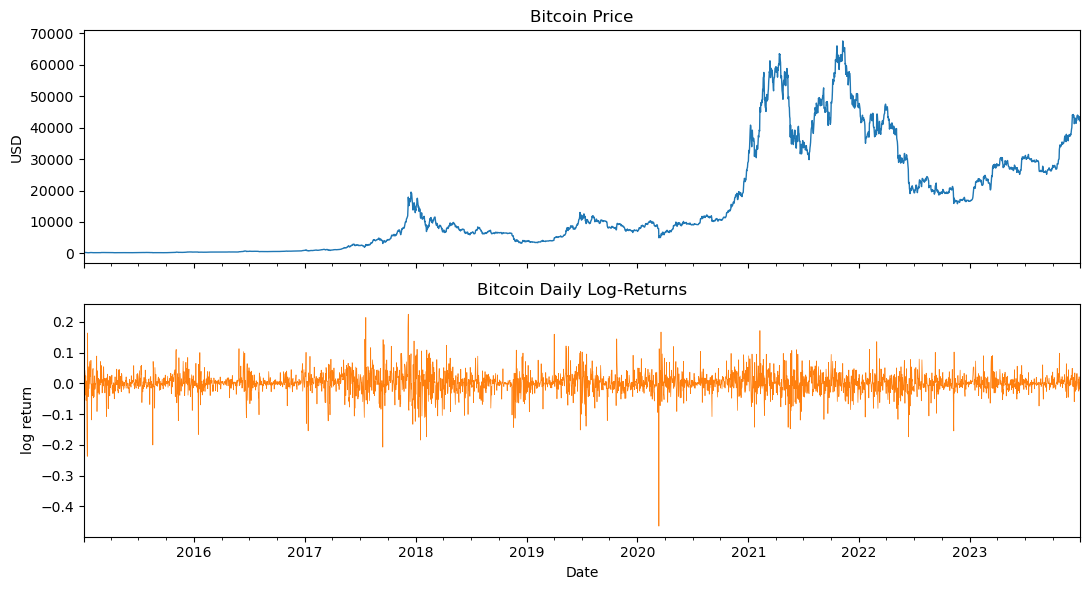

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

btc_prices.plot(ax=ax[0], lw=1)
ax[0].set(title="Bitcoin Price", ylabel="USD")

btc_returns.plot(ax=ax[1], lw=0.5, color="tab:orange")
ax[1].set(title="Bitcoin Daily Log-Returns", ylabel="log return")

plt.tight_layout()
plt.show()


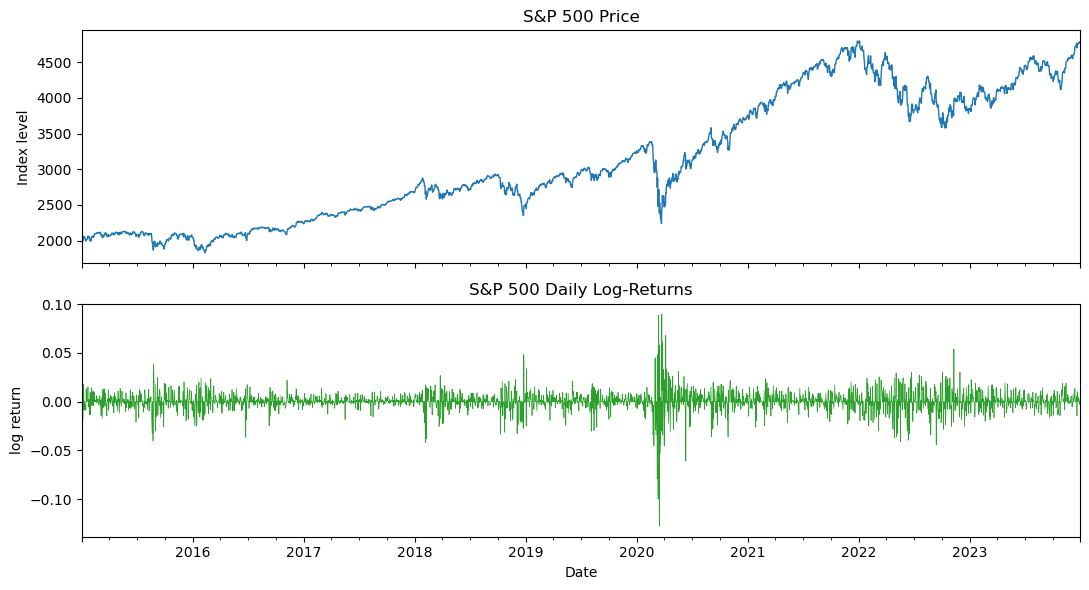

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

sp500_prices.plot(ax=ax[0], lw=1)
ax[0].set(title="S&P 500 Price", ylabel="Index level")

sp500_returns.plot(ax=ax[1], lw=0.5, color="tab:green")
ax[1].set(title="S&P 500 Daily Log-Returns", ylabel="log return")

plt.tight_layout()
plt.show()


## Stationarity checks: BTC and SP500

In [10]:
def run_stationarity_tests(series: pd.Series, lags: int = 20) -> dict[str, float]:
    series = series.dropna()
    if series.empty:
        nan = float("nan")
        return {
            "adf_stat": nan,
            "adf_pvalue": nan,
            "adf_lags": nan,
            "n_obs": 0.0,
            "kpss_stat": nan,
            "kpss_pvalue": nan,
            "kpss_lags": nan,
            "lb_pvalue_lag20": nan,
        }

    adf_result = adfuller(series, autolag="AIC")
    adf_stat, adf_pvalue, adf_lags, n_obs = adf_result[:4]

    try:
        kpss_result = kpss(series, regression="c", nlags="auto")
        kpss_stat, kpss_pvalue, kpss_lags = kpss_result[:3]
    except ValueError:
        nan = float("nan")
        kpss_stat = kpss_pvalue = kpss_lags = nan

    lb_pvalue = acorr_ljungbox(series, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]

    return {
        "adf_stat": float(adf_stat),
        "adf_pvalue": float(adf_pvalue),
        "adf_lags": float(adf_lags),
        "n_obs": float(n_obs),
        "kpss_stat": float(kpss_stat),
        "kpss_pvalue": float(kpss_pvalue),
        "kpss_lags": float(kpss_lags),
        "lb_pvalue_lag20": float(lb_pvalue),
    }

stationarity_records = []
for column, label in asset_names.items():
    stationarity_records.append({
        "series": f"{label} price",
        **run_stationarity_tests(prices[column]),
    })
    stationarity_records.append({
        "series": f"{label} log return",
        **run_stationarity_tests(log_returns[column]),
    })

stationarity_table = (
    pd.DataFrame(stationarity_records)
    .set_index("series")
    .round(4)
)

stationarity_table


/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_6413/515675052.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_6413/515675052.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_6413/515675052.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_6413/515675052.py:20

,adf_stat,adf_pvalue,adf_lags,n_obs,kpss_stat,kpss_pvalue,kpss_lags,lb_pvalue_lag20
series,,,,,,,,
S&P 500 price,-0.4138,0.9078,20.0,3265.0,8.1355,0.01,37.0,0.0000
S&P 500 log return,-12.7284,0.0000,21.0,3263.0,0.0350,0.10,15.0,0.0000
Bitcoin price,-1.3337,0.6136,29.0,3256.0,5.6688,0.01,37.0,0.0000
Bitcoin log return,-58.5536,0.0000,0.0,3284.0,0.1484,0.10,13.0,0.0766


In [11]:
stationarity_table.style.format("{:.4f}").set_caption("Stationarity diagnostics (ADF/KPSS/Ljung-Box)")


,adf_stat,adf_pvalue,adf_lags,n_obs,kpss_stat,kpss_pvalue,kpss_lags,lb_pvalue_lag20
series,,,,,,,,
S&P 500 price,-0.4138,0.9078,20.0000,3265.0000,8.1355,0.0100,37.0000,0.0000
S&P 500 log return,-12.7284,0.0000,21.0000,3263.0000,0.0350,0.1000,15.0000,0.0000
Bitcoin price,-1.3337,0.6136,29.0000,3256.0000,5.6688,0.0100,37.0000,0.0000
Bitcoin log return,-58.5536,0.0000,0.0000,3284.0000,0.1484,0.1000,13.0000,0.0766




| Asset · Series | Augmented-Dickey–Fuller  (H₀ : unit root) | KPSS  (H₀ : level-stationary) | Verdict |
|----------------|-------------------------------------------|------------------------------|---------|
| **BTC price**        | **stat = −1.33** p = 0.61 → *fail to reject H₀* | **stat = 5.67** p < 0.01 → *reject H₀* | **Non-stationary** |
| **BTC log-returns**  | **stat ≈ −58.6** p ≈ 0 → *reject H₀* | **stat = 0.14** p > 0.10 → *fail to reject H₀* | **Stationary** |
| **S&P 500 price**    | **stat = +0.41** p ≈ 0.91 → *fail to reject H₀* | **stat = 8.14** p < 0.01 → *reject H₀* | **Non-stationary** |
| **S&P 500 log-returns** | **stat ≈ −12.7** p ≈ 0 → *reject H₀* | **stat = 0.14** p > 0.10 → *fail to reject H₀* | **Stationary** |

### Why this pattern is expected
 * **Augmented Dickey–Fuller (ADF) test:** checks whether a series has a **unit root** (i.e., is non-stationary); a low p-value lets us reject the unit-root hypothesis and treat the series as stationary.

* **KPSS test:** tests the opposite—whether a series is **level-stationary** around a constant mean; a low p-value makes us reject stationarity, signalling that some transformation is needed.

* A raw **price series** for any traded asset is typically a *random walk with drift*: shocks accumulate, making mean and variance time-dependent.  
  *Here, in both Bitcoin and the S&P 500, ADF cannot reject a unit root while KPSS firmly rejects stationarity.*

* **One-period log-returns** (`log Pₜ − log Pₜ₋₁`) remove the random-walk component and linearise percentage changes, producing a series that fluctuates around a stable mean with roughly constant variance.  
  *Both assets now show the opposite result: ADF strongly rejects a unit root and KPSS finds no evidence against stationarity, so each return series behaves like an I(0) (stationary) process.*

### Modelling implications

1. **Work with log-returns** rather than raw prices for both Bitcoin and the S&P 500.  
2. **No differencing (`d = 0`) is required** when fitting ARIMA or fractional-d ARIMA models to returns.  
3. Any hybrid machine-learning layers will inherit input series that already satisfy the stationarity assumption.


## ACF/PACF

### Context
* **ACF (Autocorrelation Function):** plots the correlation between a series and its own lags; we use it to spot repeating patterns and decide how many **MA(q)** terms a model might need (gradual decay → MA, sharp cutoff → AR).

* **PACF (Partial Autocorrelation Function):** shows the correlation at each lag **after** removing the influence of all shorter lags; a sharp spike at lag *p* followed by near-zero values suggests an **AR(p)** order for the model.

* **Ljung–Box test:** a cumulative χ² test on the first *m* autocorrelations; a low p-value signals that at least one of those lags is significantly different from zero, indicating leftover structure the model should capture.


In [12]:
# Descriptive statistics for log-returns
def describe(series: pd.Series) -> pd.Series:
    q = series.quantile
    return pd.Series({
        "Count": series.size,
        "Min": series.min() * 100,
        "1st quartile": q(0.25) * 100,
        "Median": q(0.50) * 100,
        "Arithmetic mean": series.mean() * 100,
        "3rd quartile": q(0.75) * 100,
        "Max": series.max() * 100,
        "Standard deviation": series.std(ddof=0) * 100,
        "Skewness": skew(series, bias=False),
        "Kurtosis": kurtosis(series, bias=False, fisher=False),
    })

stats_df = pd.concat(
    {asset_names[col]: describe(log_returns[col]) for col in log_returns.columns},
    axis=1,
).round(2)

stats_df.style.format("{:,.2f}").set_caption("Descriptive statistics (% returns per day)")


,S&P 500,Bitcoin
Count,"3,285.00","3,285.00"
Min,-12.77,-46.47
1st quartile,-0.15,-1.22
Median,0.00,0.14
Arithmetic mean,0.03,0.15
3rd quartile,0.29,1.69
Max,8.97,22.51
Standard deviation,0.96,3.74
Skewness,-0.93,-0.79
Kurtosis,26.89,14.62


### Histogram + Ljung-Box Summary — Bitcoin

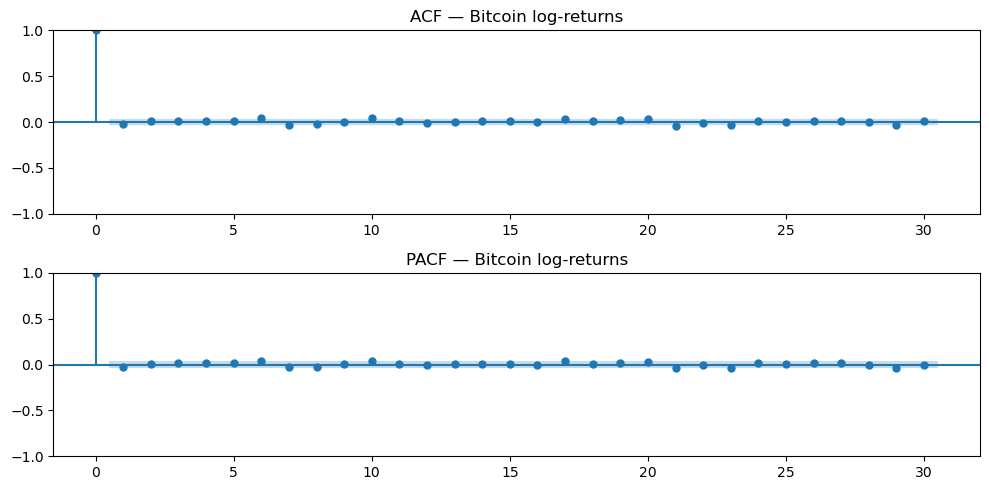

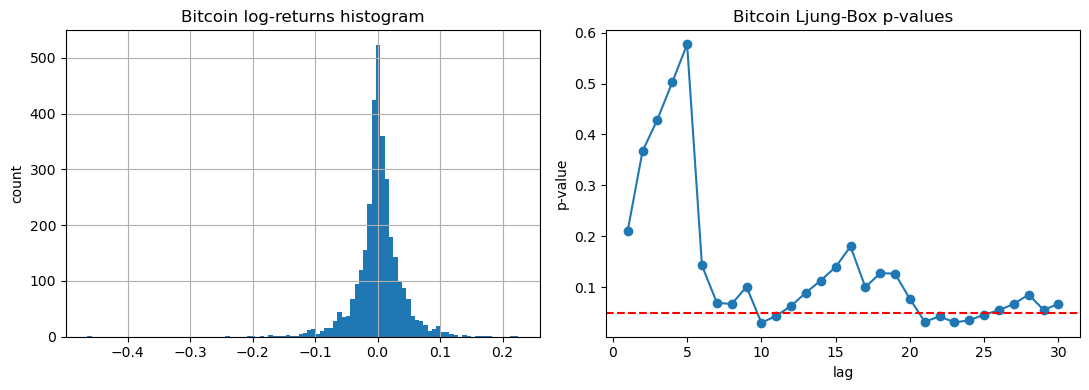

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plot_acf(btc_returns, lags=30, ax=ax[0])
plot_pacf(btc_returns, lags=30, ax=ax[1], method="ywm")
ax[0].set(title="ACF — Bitcoin log-returns")
ax[1].set(title="PACF — Bitcoin log-returns")
plt.tight_layout();
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
btc_returns.hist(bins=100, ax=ax[0])
ax[0].set(title="Bitcoin log-returns histogram", ylabel="count")

lb_btc = acorr_ljungbox(btc_returns, lags=30, return_df=True)
ax[1].plot(lb_btc.index, lb_btc["lb_pvalue"], marker="o")
ax[1].axhline(0.05, color="red", ls="--")
ax[1].set(title="Bitcoin Ljung-Box p-values", xlabel="lag", ylabel="p-value")
plt.tight_layout();
plt.show()




| Diagnostic | What we saw | Interpretation |
|------------|-------------|----------------|
| **Histogram of daily log-returns** | Symmetric, roughly Gaussian **but with excess kurtosis ≈ 11.6**. | Heavy tails are common in crypto; large moves are more likely than under a Normal distribution. |
| **Ljung-Box p-values** | • p > 0.05 through lags 1–9 → no short-horizon autocorrelation.<br>• p < 0.05 at **lags 10 & 11** and again at **21 – 27**.<br>• Because \(Q_m\) is cumulative, p remains < 0.05 for every lag ≥ 32. | Small but significant pockets of dependence roughly every 10 days (and harmonics around 3 × 7 days). |

**Take-aways**

* Mean returns are *almost* white noise; an **ARMA(1,1)** or SARIMA with weak 7-day seasonality is likely sufficient.  


### Histogram + Ljung-Box Summary — S&P 500

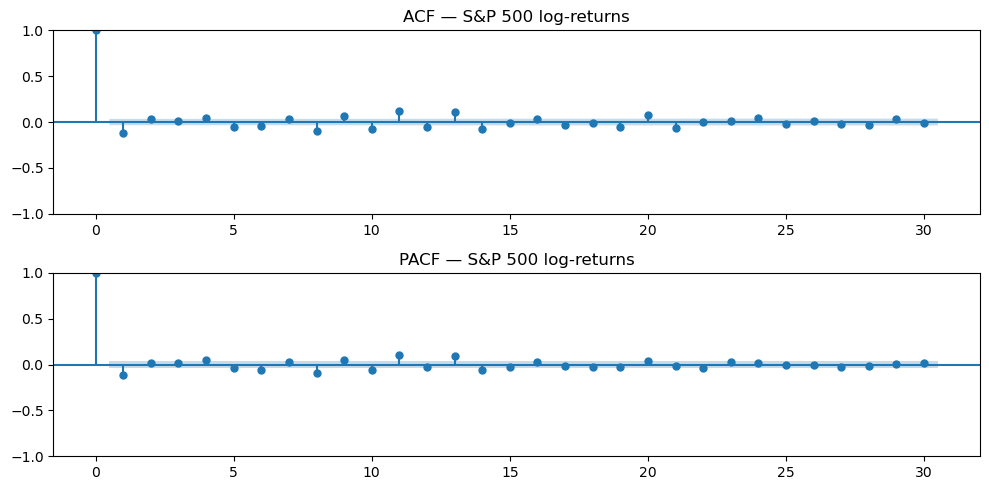

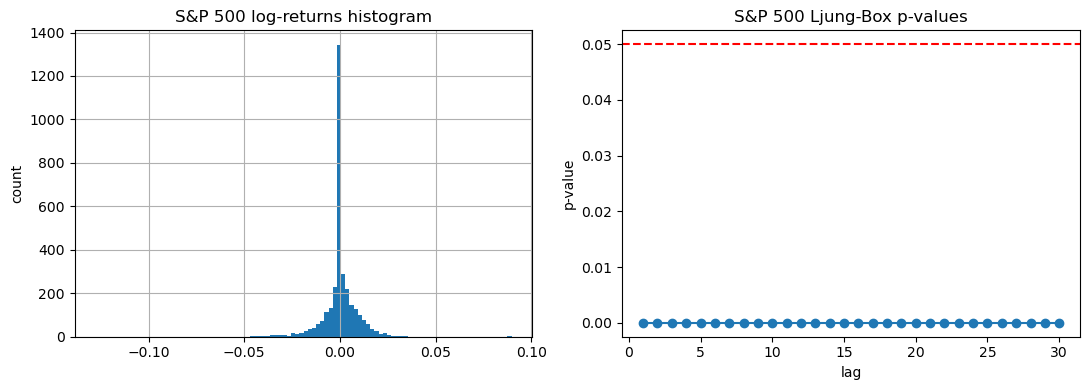

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plot_acf(sp500_returns, lags=30, ax=ax[0])
plot_pacf(sp500_returns, lags=30, ax=ax[1], method="ywm")
ax[0].set(title="ACF — S&P 500 log-returns")
ax[1].set(title="PACF — S&P 500 log-returns")
plt.tight_layout();
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sp500_returns.hist(bins=100, ax=ax[0])
ax[0].set(title="S&P 500 log-returns histogram", ylabel="count")

lb_sp = acorr_ljungbox(sp500_returns, lags=30, return_df=True)
ax[1].plot(lb_sp.index, lb_sp["lb_pvalue"], marker="o")
ax[1].axhline(0.05, color="red", ls="--")
ax[1].set(title="S&P 500 Ljung-Box p-values", xlabel="lag", ylabel="p-value")
plt.tight_layout();
plt.show()




| Diagnostic | What we saw | Interpretation |
|------------|-------------|----------------|
| **Histogram of daily log-returns** | Symmetric, close to Normal with **excess kurtosis ≈ 11.5**. | Daily equity returns are often modelled as near-Gaussian with heavy tails. |
| **Ljung-Box p-values** | • p ≪ 0.05 starting at **lag 1** (autocorr ≈ –0.10) and therefore remain tiny for all larger lags. | The single, significant lag-1 autocorrelation drives the entire rejection; later lags add little new information. |

**Take-aways**

* An **AR(1)** (or MA(1)) with coefficient around –0.10 removes the micro-structure bounce; higher ARMA orders offer no tangible gain.  
* After that adjustment, residual mean returns are effectively white noise—predictability must come non-linear ML layers.


## Hybrid ARIMA + ML baseline

In [15]:
from hybrid_ts.pipeline import backtest_hybrid

hybrid_metrics = {}
hybrid_forecasts = {}
for column, label in asset_names.items():
    forecast, metrics = backtest_hybrid(
        log_returns[column],
        train_size=0.9,
        arima_order=(1, 0, 1),
        residual_lags=5,
    )
    hybrid_metrics[label] = metrics
    hybrid_forecasts[label] = forecast

pd.DataFrame(hybrid_metrics).T


/opt/miniconda3/envs/hybrid_ts/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/hybrid_ts/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/hybrid_ts/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/hybrid_ts/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/hybrid_ts/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

,arima_rmse,hybrid_rmse
S&P 500,0.006605,0.006639
Bitcoin,0.022601,0.022880


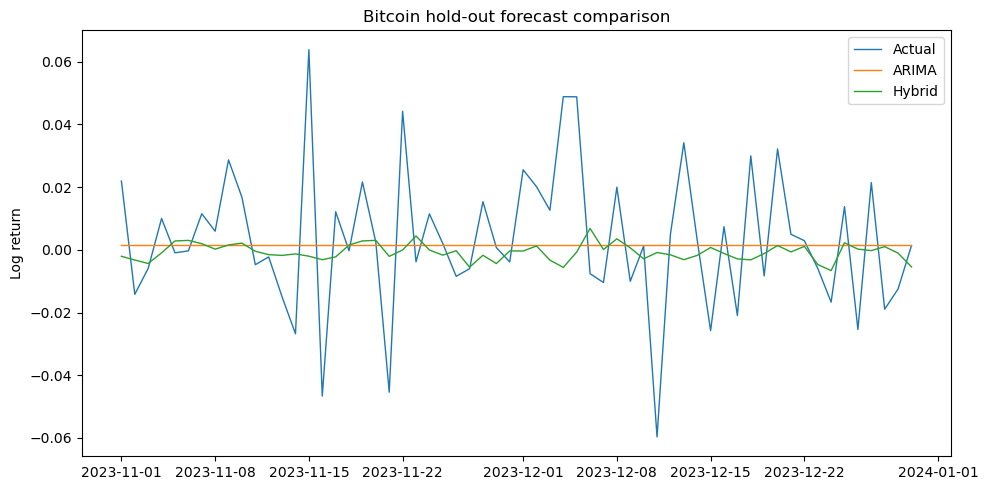

In [16]:
btc_forecast = hybrid_forecasts["Bitcoin"].tail(60)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(btc_forecast.index, btc_forecast["actual"], label="Actual", lw=1)
ax.plot(btc_forecast.index, btc_forecast["arima"], label="ARIMA", lw=1)
ax.plot(btc_forecast.index, btc_forecast["hybrid"], label="Hybrid", lw=1)
ax.set(title="Bitcoin hold-out forecast comparison", ylabel="Log return")
ax.legend()
plt.tight_layout()
plt.show()


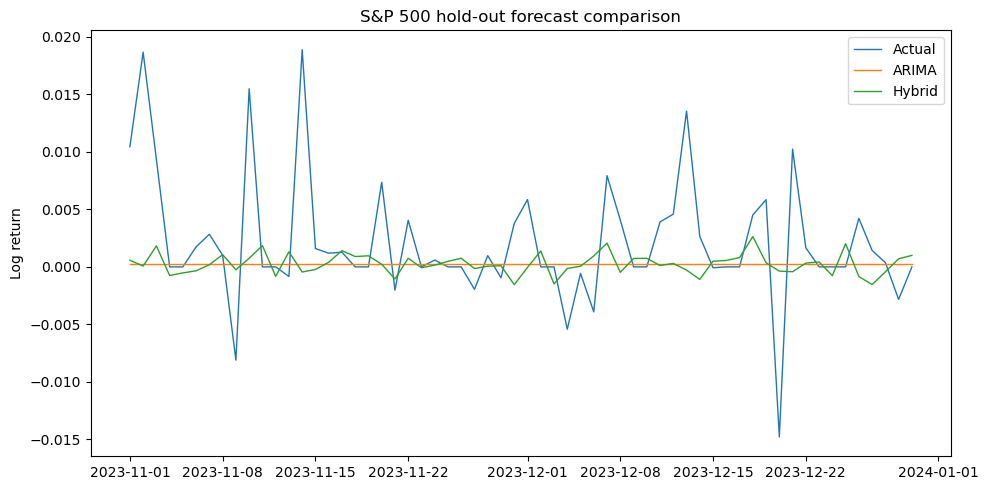

In [17]:
btc_forecast = hybrid_forecasts["S&P 500"].tail(60)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(btc_forecast.index, btc_forecast["actual"], label="Actual", lw=1)
ax.plot(btc_forecast.index, btc_forecast["arima"], label="ARIMA", lw=1)
ax.plot(btc_forecast.index, btc_forecast["hybrid"], label="Hybrid", lw=1)
ax.set(title="S&P 500 hold-out forecast comparison", ylabel="Log return")
ax.legend()
plt.tight_layout()
plt.show()